In [1]:
import os
import pandas as pd  # type: ignore
import numpy as np  # type: ignore

FIGSIZE = (20, 6)

# Going one step further!

Since PSR's Hera is a software about helping predict the best location for building dams, I thought it would be fun to try to mimick that purpose in a little prototype.

In that regard, let's try to build a little software that take some **coordinates, or a station code** and a **radius in km**, delimits that region $\alpha$, and returns us the **forecasts for sun radiation** for all the metereological stations inside $\alpha$

### Trying to compare the stations

For that, we have to find a way to compare each station by geolocation. In this prototype, I'll store everything in a `pandas.DataFrame`

In [2]:
file_dir = "inmet-data"
years = [i.name for i in os.scandir(f"{file_dir}") if i.is_dir()]
filenames = []
for y in years:
    filenames.extend(
        [f"{file_dir}/{y}/{f.name}" for f in os.scandir(f"{file_dir}/{y}")]
    )

len(filenames)

9460

In [3]:
cols = [
    "year",
    "region",
    "state",
    "station-name",
    "code",
    "lat",
    "lon",
    "height",
    "starts_on",
]

In [4]:
df = pd.DataFrame(columns=cols)

for i, f in enumerate(filenames):
    file = open(f, "r", encoding="iso-8859-1")
    data = [f.split("/")[1]]
    for i in range(8):
        line = file.readline()
        data.append(line.split(";")[1][:-1])
    df.loc[len(df.index)] = dict(zip(cols, data))

df["lat"] = df["lat"].apply(lambda n: np.float64(n.replace(",", ".")))
df["lon"] = df["lon"].apply(lambda n: np.float64(n.replace(",", ".")))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9460 entries, 0 to 9459
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          9460 non-null   object 
 1   region        9460 non-null   object 
 2   state         9460 non-null   object 
 3   station-name  9460 non-null   object 
 4   code          9460 non-null   object 
 5   lat           9460 non-null   float64
 6   lon           9460 non-null   float64
 7   height        9460 non-null   object 
 8   starts_on     9460 non-null   object 
dtypes: float64(2), object(7)
memory usage: 739.1+ KB


### 

### Querying data for stations inside radius

With the DataFrame build, we can filter data more freely, and we can start to think about building something that can initialize our `ForecastPicker`.

In [5]:
from src.geolocation_utils import in_radius_from_station_code

city = "A627"
in_radius = df.loc[in_radius_from_station_code(df, city, 120)]
in_radius_dict = {
    i: in_radius.loc[in_radius.code == city, "year"].unique()
    for i in in_radius["code"].unique()
}

in_radius_dict.keys()

dict_keys(['A629', 'A625', 'A606', 'A611', 'A618', 'A621', 'A667', 'A610', 'A627', 'A659', 'A602', 'A624', 'A652', 'A601', 'A636', 'A626', 'A603', 'A637'])

### Creating useful DataFrames for forecasting radiation

`group_datasets_by_location` takes a location code and an array of years, which we now have!

We can map the newly created `DataFrame`s by location code and use them to populate `ForecastPicker`

In [6]:
from src.read_input import group_datasets_by_location, format_dataset
from src.grouping_data import group_df_by_day, make_rolling_window

dfs = {}
for code in in_radius_dict:
    formatted = format_dataset(group_datasets_by_location(code, in_radius_dict[code]))
    dfs[code] = make_rolling_window(group_df_by_day(formatted))

## Comparing Forecasts for each station

Now that we have all the needed information in dataframes, we can use `ForecastPicker` to automate choosing the best Forecasting model for each case in a few lines of code:

In [7]:
from src.forecasting.forecast_picker import ForecastPicker
from src.utils import DEFAULT_TARGET_COLUMN, DEFAULT_INDEX_COLUMN
from sklearn.metrics import mean_absolute_percentage_error
import logging

logging.getLogger("cmdstanpy").setLevel(logging.WARNING)  # make prophet less verbose

/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [8]:
target = DEFAULT_TARGET_COLUMN
idx = DEFAULT_INDEX_COLUMN

date_threshold = pd.to_datetime("2023", format="%Y")
date_upper = date_threshold + pd.DateOffset(months=6)

logging.getLogger("cmdstanpy").setLevel(logging.WARNING)  # make prophet less verbose

fps = {}
failures = {}
for code, df in dfs.items():
    print(f"preparing {code}...", end="\t")
    try:
        fps[code] = ForecastPicker(
            df, date_threshold, date_upper, target, idx, mean_absolute_percentage_error
        )
        print("done!")
    except Exception as e:
        failures[code] = e
        print("error! god damnit")

if failures:
    print(
        f"unable to predict for stations {list(failures.keys())}. ignoring them for now!"
    )

preparing A629...	

14:25:45 - cmdstanpy - INFO - Chain [1] start processing
14:25:45 - cmdstanpy - INFO - Chain [1] done processing


done!
preparing A625...	error! god damnit
preparing A606...	

/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:25:46] WARNING: /workspace/src/common/error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)
14:25:46 - cmdstanpy - INFO - Chain [1] start processing
14:25:46 - cmdstanpy - INFO - Chain [1] done processing
14:25:46 - cmdstanpy - INFO - Chain [1] start processing


done!
preparing A611...	

14:25:47 - cmdstanpy - INFO - Chain [1] done processing
14:25:47 - cmdstanpy - INFO - Chain [1] start processing


done!
preparing A618...	

14:25:47 - cmdstanpy - INFO - Chain [1] done processing
14:25:48 - cmdstanpy - INFO - Chain [1] start processing


done!
preparing A621...	

14:25:48 - cmdstanpy - INFO - Chain [1] done processing
14:25:48 - cmdstanpy - INFO - Chain [1] start processing


done!
preparing A667...	

14:25:48 - cmdstanpy - INFO - Chain [1] done processing
14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing


done!
preparing A610...	

14:25:49 - cmdstanpy - INFO - Chain [1] start processing
14:25:49 - cmdstanpy - INFO - Chain [1] done processing


done!
preparing A627...	

14:25:50 - cmdstanpy - INFO - Chain [1] start processing


done!
preparing A659...	

14:25:50 - cmdstanpy - INFO - Chain [1] done processing


done!
preparing A602...	error! god damnit
preparing A624...	

14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing


done!
preparing A652...	

14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing


done!
preparing A601...	

14:25:52 - cmdstanpy - INFO - Chain [1] done processing
14:25:52 - cmdstanpy - INFO - Chain [1] start processing


done!
preparing A636...	

14:25:52 - cmdstanpy - INFO - Chain [1] done processing


done!
preparing A626...	error! god damnit
preparing A603...	

14:25:53 - cmdstanpy - INFO - Chain [1] start processing
14:25:53 - cmdstanpy - INFO - Chain [1] done processing


done!
preparing A637...	error! god damnit
unable to predict for stations ['A625', 'A602', 'A626', 'A637']. ignoring them for now!


### Showing off the results of initial comparisons:

Here we can see some of the training data. We can see a discrepancy in the generated forecasts. 

One of the main causes of that is the fact that data from the cities _aren't created equal_, and while some cities have well populated data since the 2000s, some stations have few years of reliable logging on meteorological data

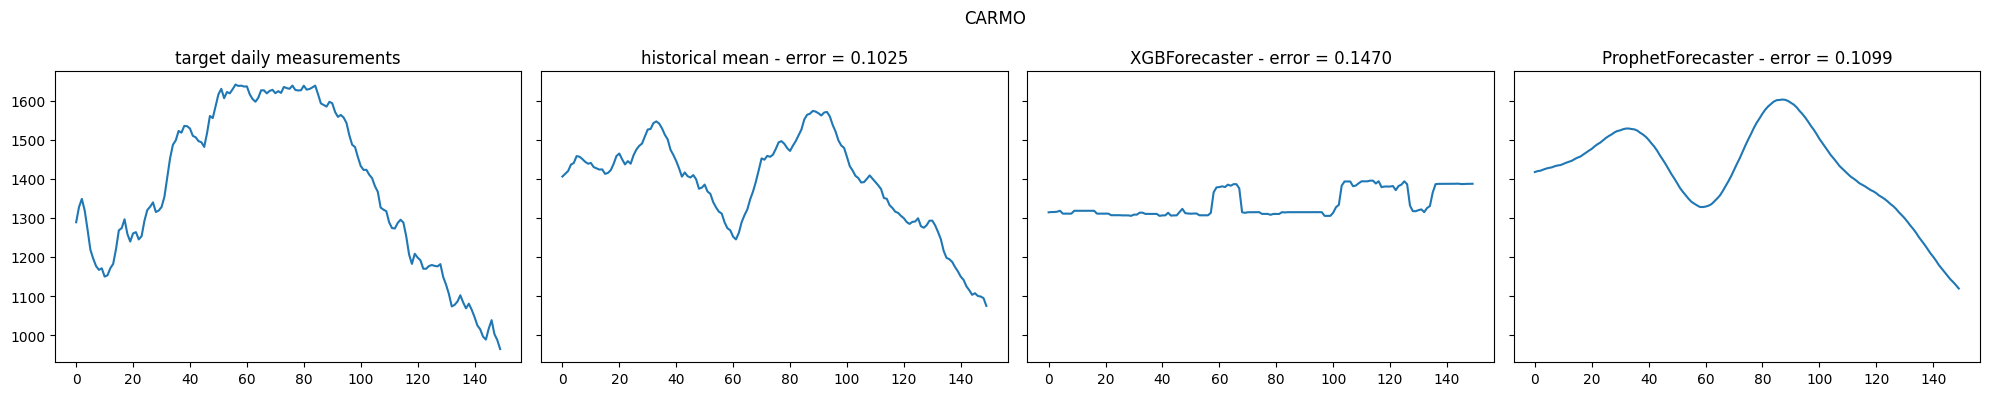

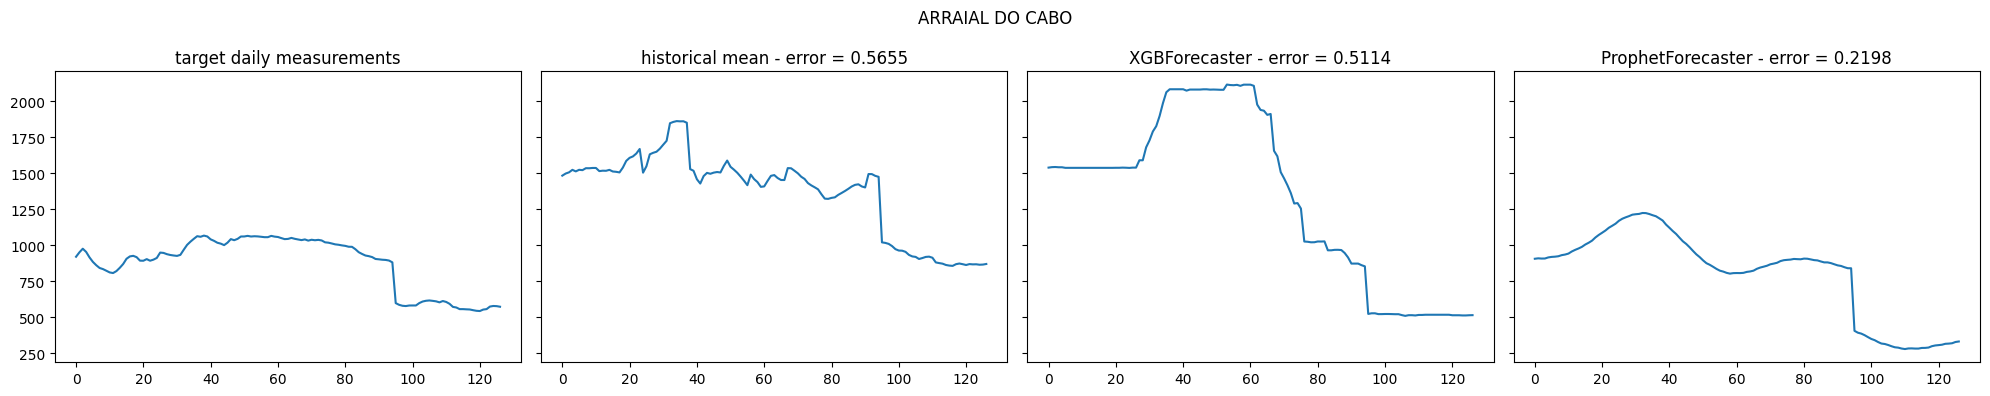

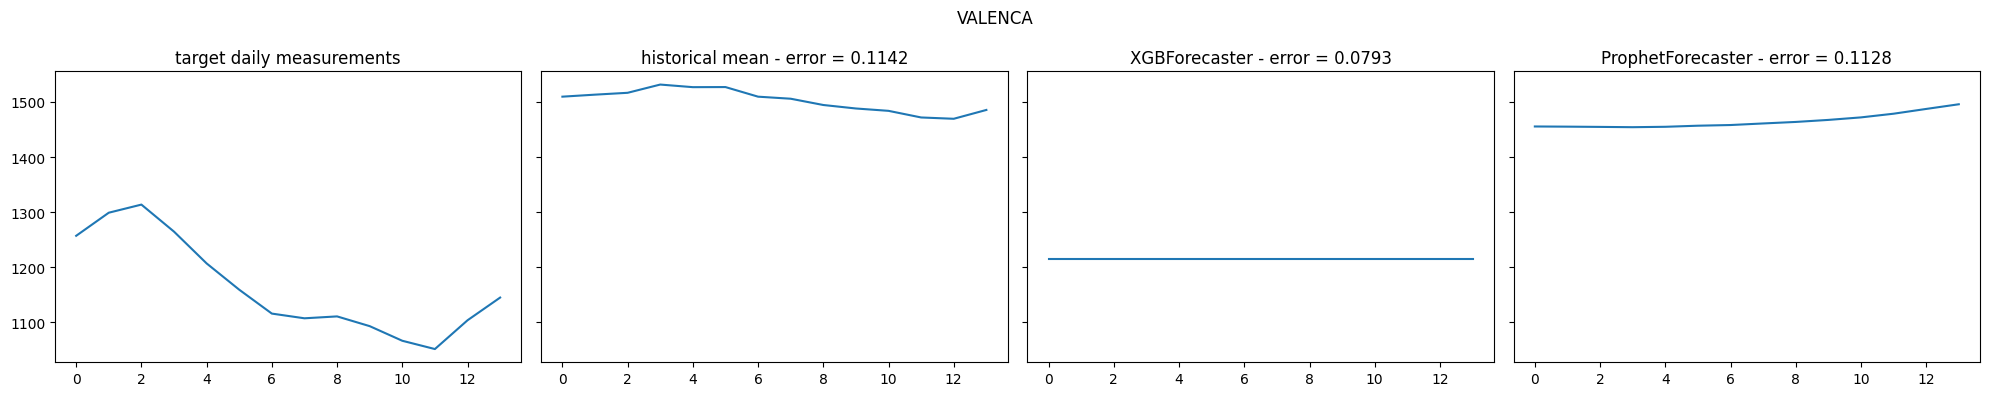

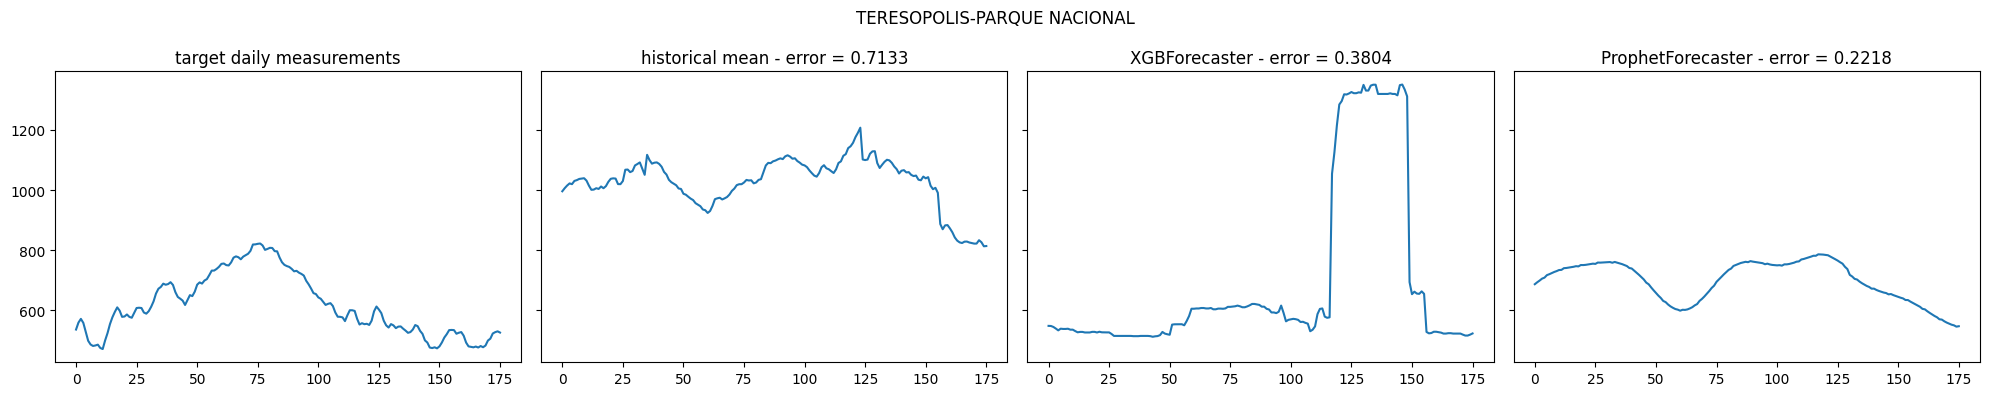

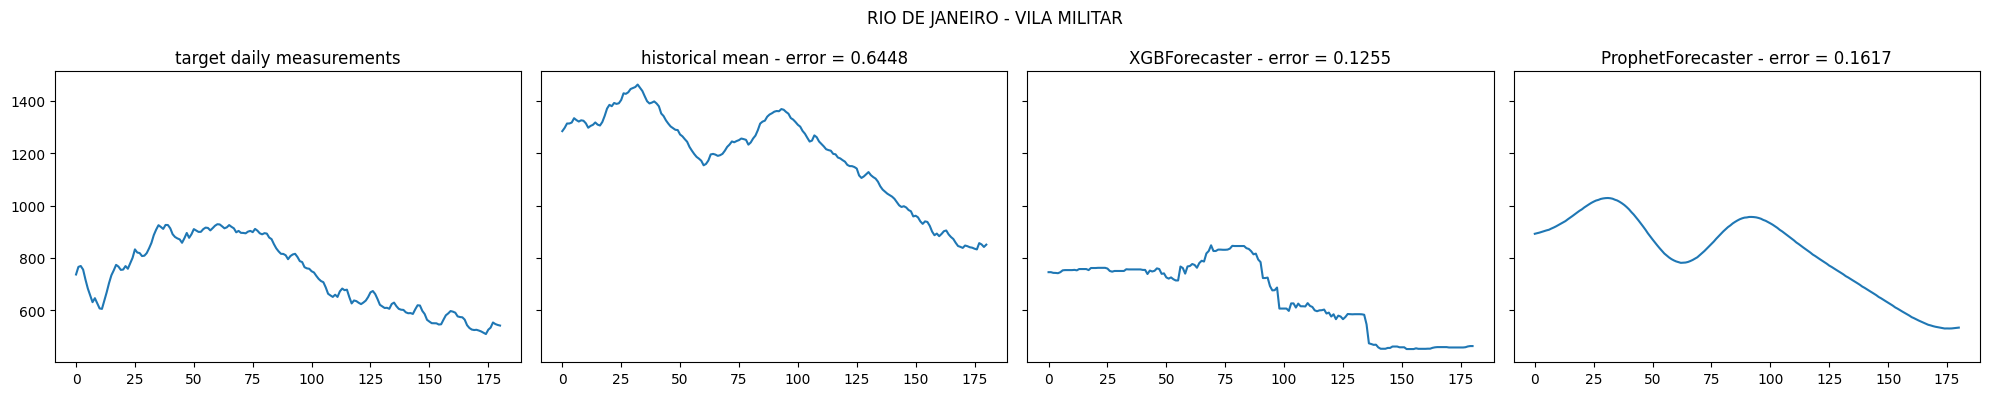

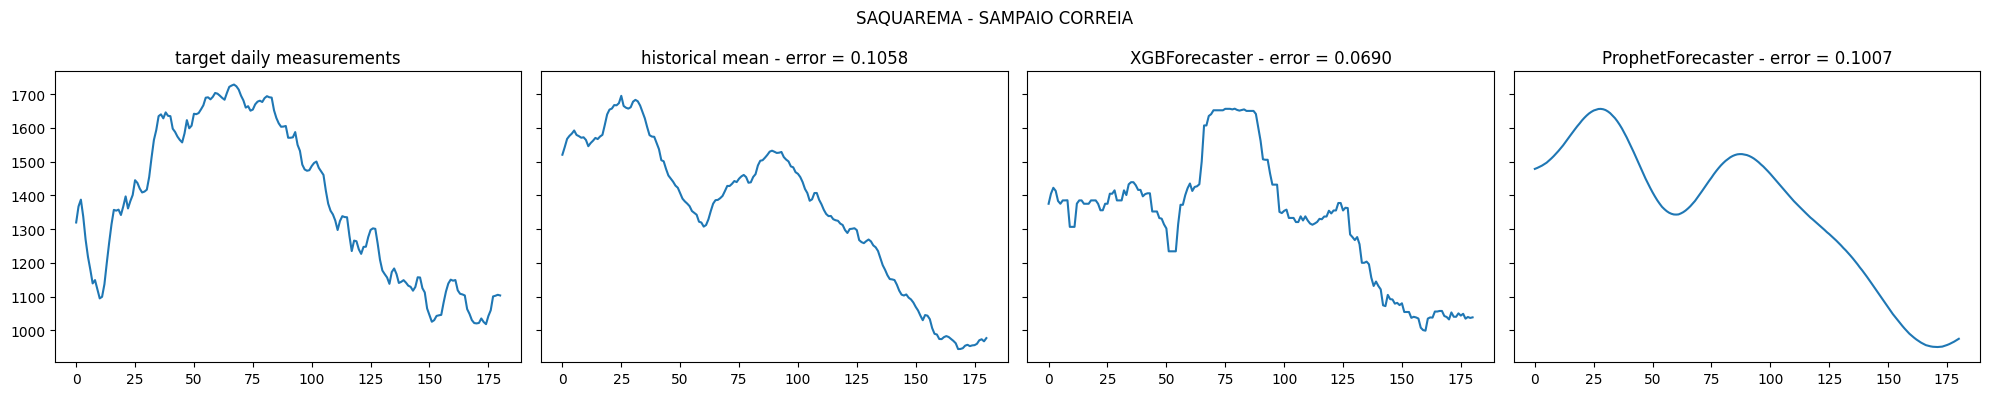

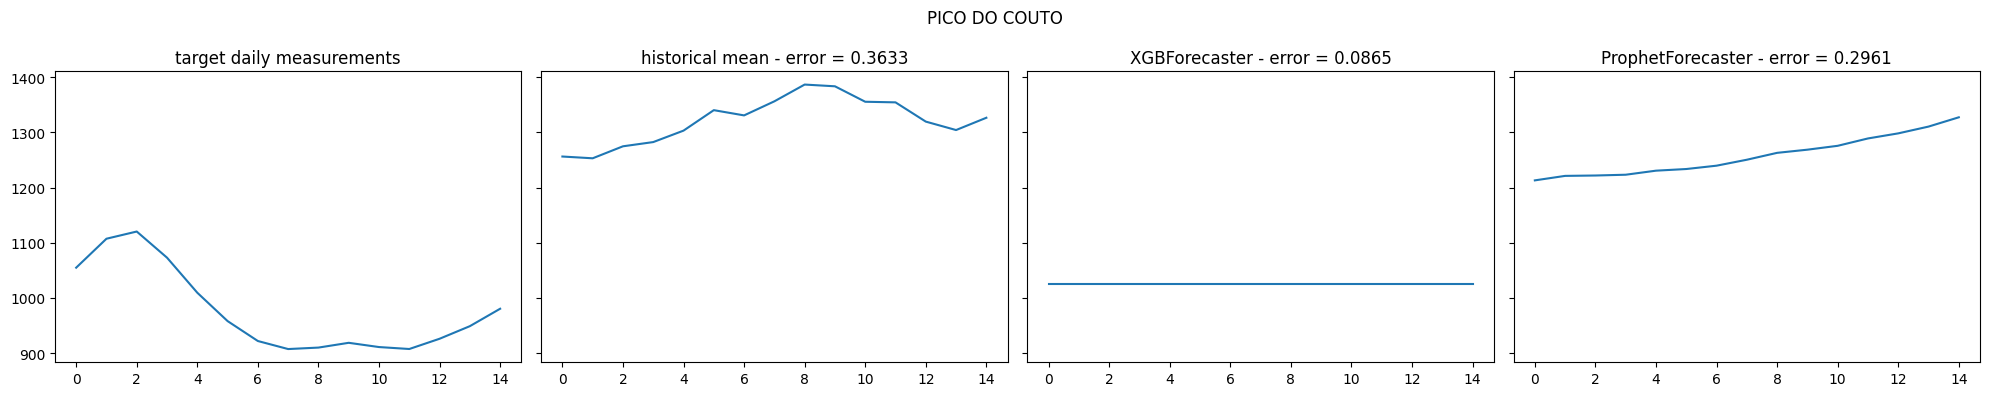

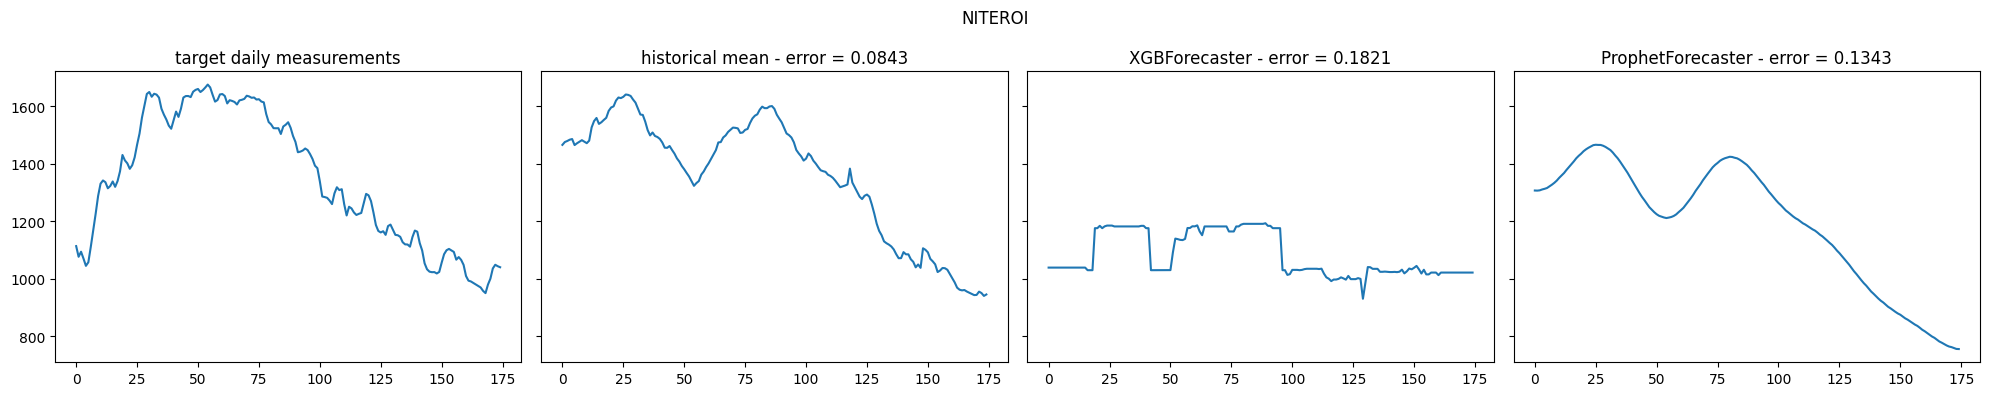

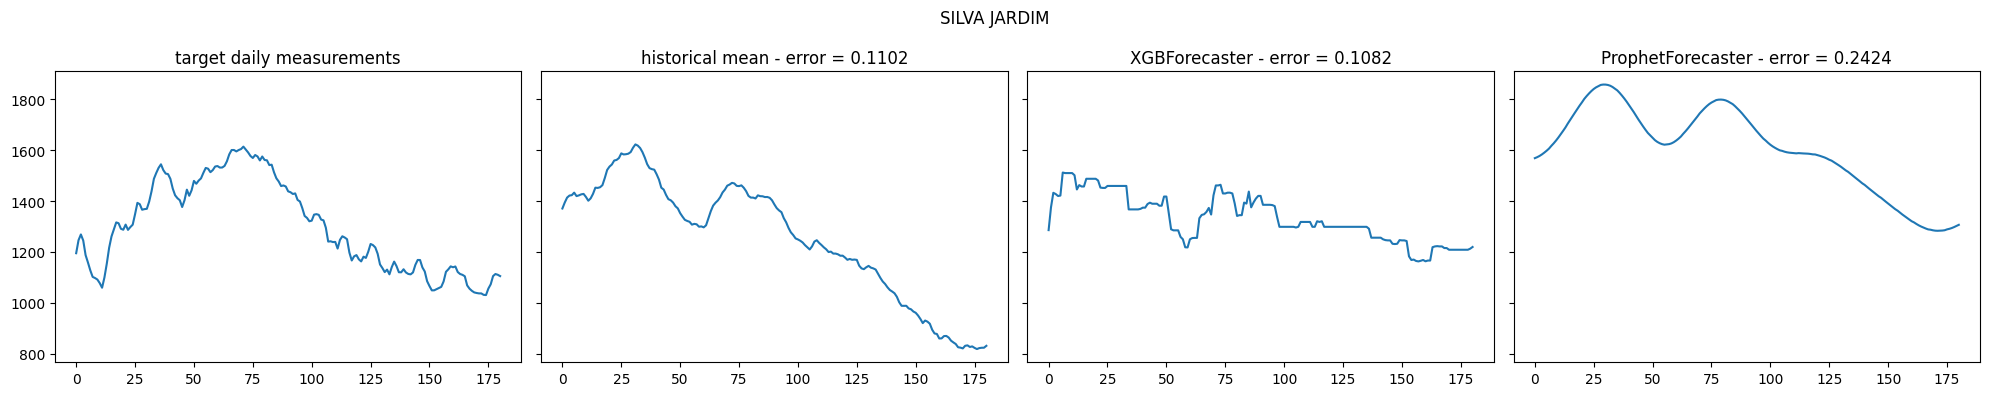

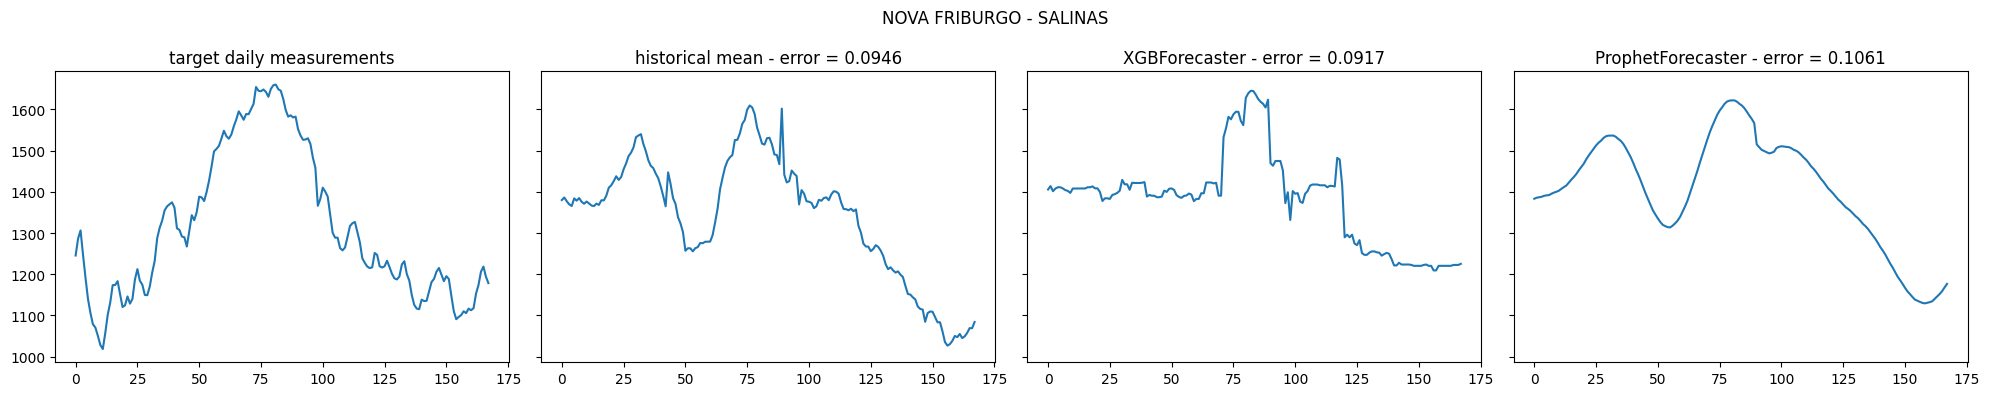

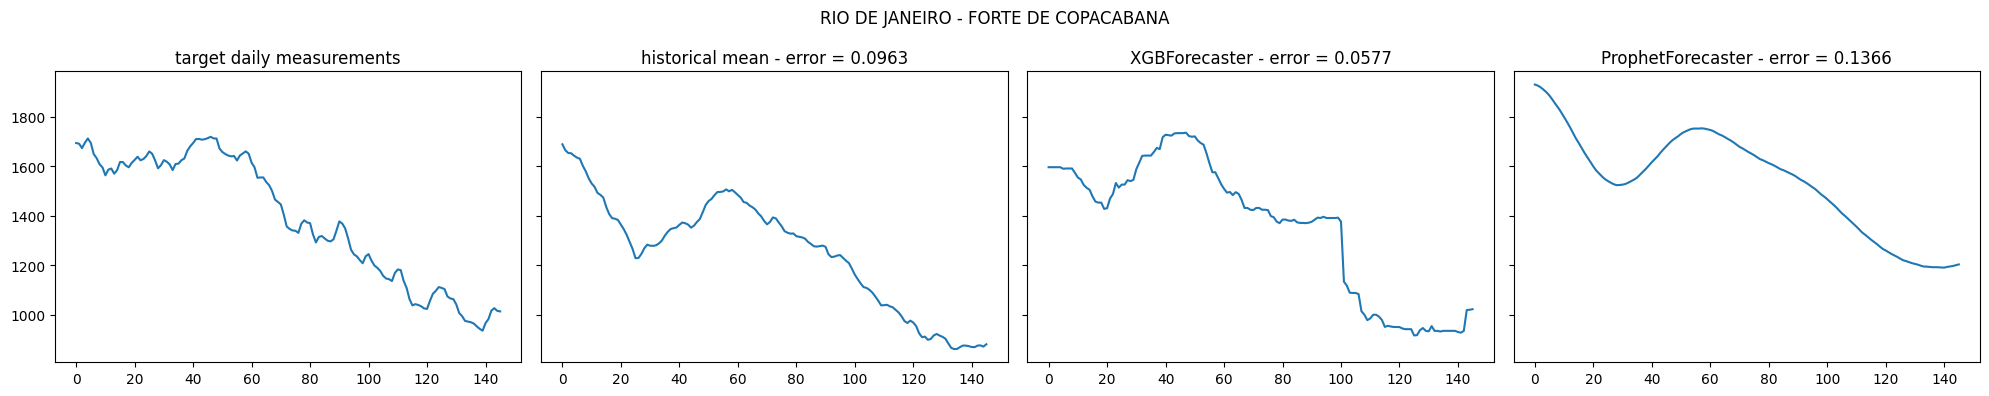

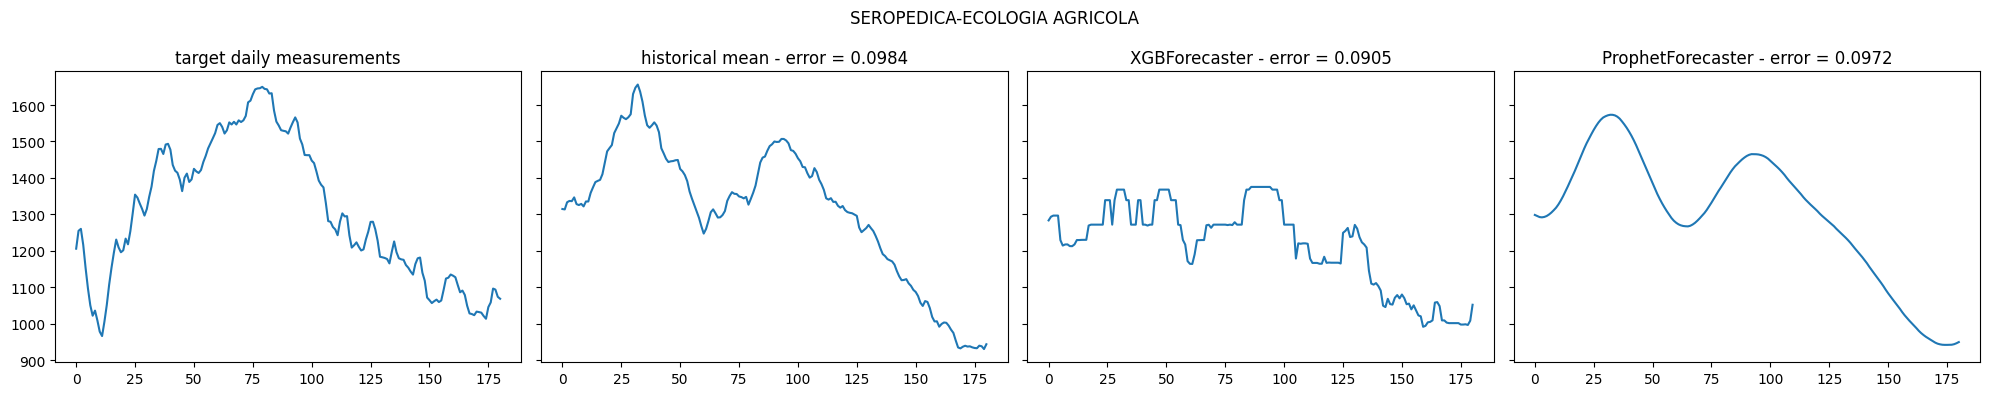

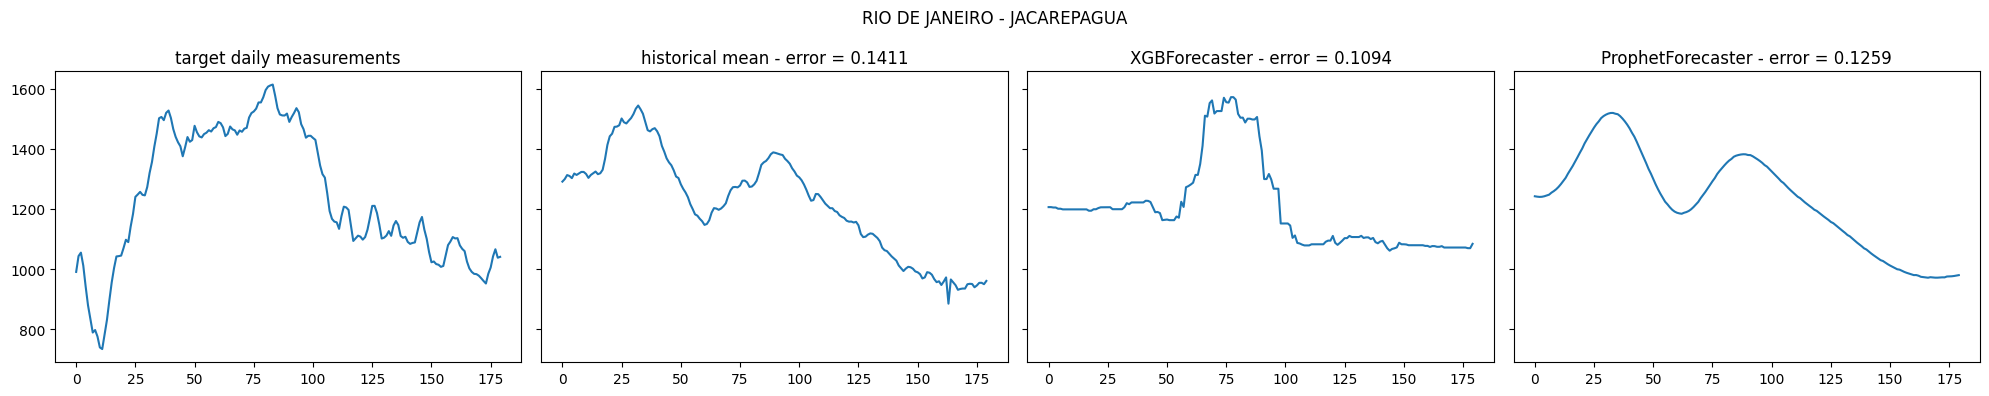

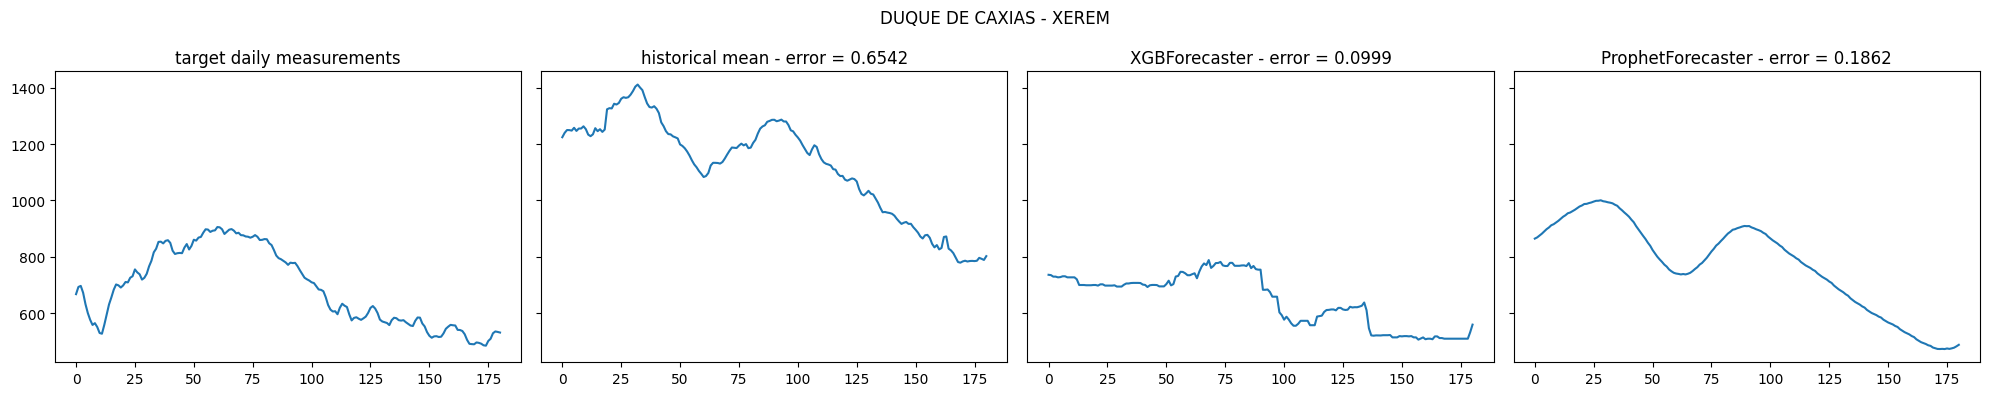

In [9]:
from matplotlib import pyplot as plt

for code, fp in fps.items():
    fig, axes = plt.subplots(1, 4, sharey=True)
    fig.set_figwidth(FIGSIZE[0])
    fig.set_figheight(4)
    fig.tight_layout()
    station_name = in_radius.loc[in_radius.code == code, "station-name"].iloc[0]
    fig.suptitle(station_name)
    comparison = fp.compare_predictions()
    for i, c in enumerate(sorted(comparison.columns, reverse=True)):
        ax = axes[i]
        ax.set_title(c)
        comparison[c].plot(ax=ax)
    plt.tight_layout()

### Making predictions

As easy as it was in the last slides, we can make our predictions by calling the method `make_prediction` in our instances of `ForecastPicker`

In [10]:
from typing import Dict

prediction_start = pd.to_datetime("2024-05-31", format="%Y-%m-%d")

predictions: Dict[str, pd.DataFrame] = {
    code: fp.make_prediction(prediction_start) for code, fp in fps.items()
}

{code: prediction.prediction.sum() for code, prediction in predictions.items()}

14:26:00 - cmdstanpy - INFO - Chain [1] start processing
14:26:00 - cmdstanpy - INFO - Chain [1] done processing
14:26:01 - cmdstanpy - INFO - Chain [1] start processing
14:26:01 - cmdstanpy - INFO - Chain [1] done processing
14:26:02 - cmdstanpy - INFO - Chain [1] start processing
14:26:02 - cmdstanpy - INFO - Chain [1] done processing
14:26:03 - cmdstanpy - INFO - Chain [1] start processing
14:26:03 - cmdstanpy - INFO - Chain [1] done processing


{'A629': 206486.8007749786,
 'A606': 128200.77904321918,
 'A611': 237150.94,
 'A618': 90145.649321106,
 'A621': 126348.41,
 'A667': 227549.16,
 'A610': 224640.97,
 'A627': 168464.5271639789,
 'A659': 222833.16,
 'A624': 238931.69,
 'A652': 225557.16,
 'A601': 226214.88,
 'A636': 222815.69,
 'A603': 131944.03}

### Comparing results

Here we can see the projected radiation for each location, sorted by greatest.

In theory, this would allow a client to make a better decision as to where he could build the most efficient solar energy generation facility

### Final Considerations

Unfortunately, I didn't have enough time wrap this in a more digestible module, but that would be relatively easy to do.

I tried to make everything as decoupled as possible, so most pieces of software should be reusable, be it for the `ForecastPicker` part of the code, or the INMET data.

I'd like to thank Arnaldo Gualberto for the time series forecasting tips, Ana Alt and Eduardo Iglesias for the lead on what databases to get information and all the ideas about solar energy generation

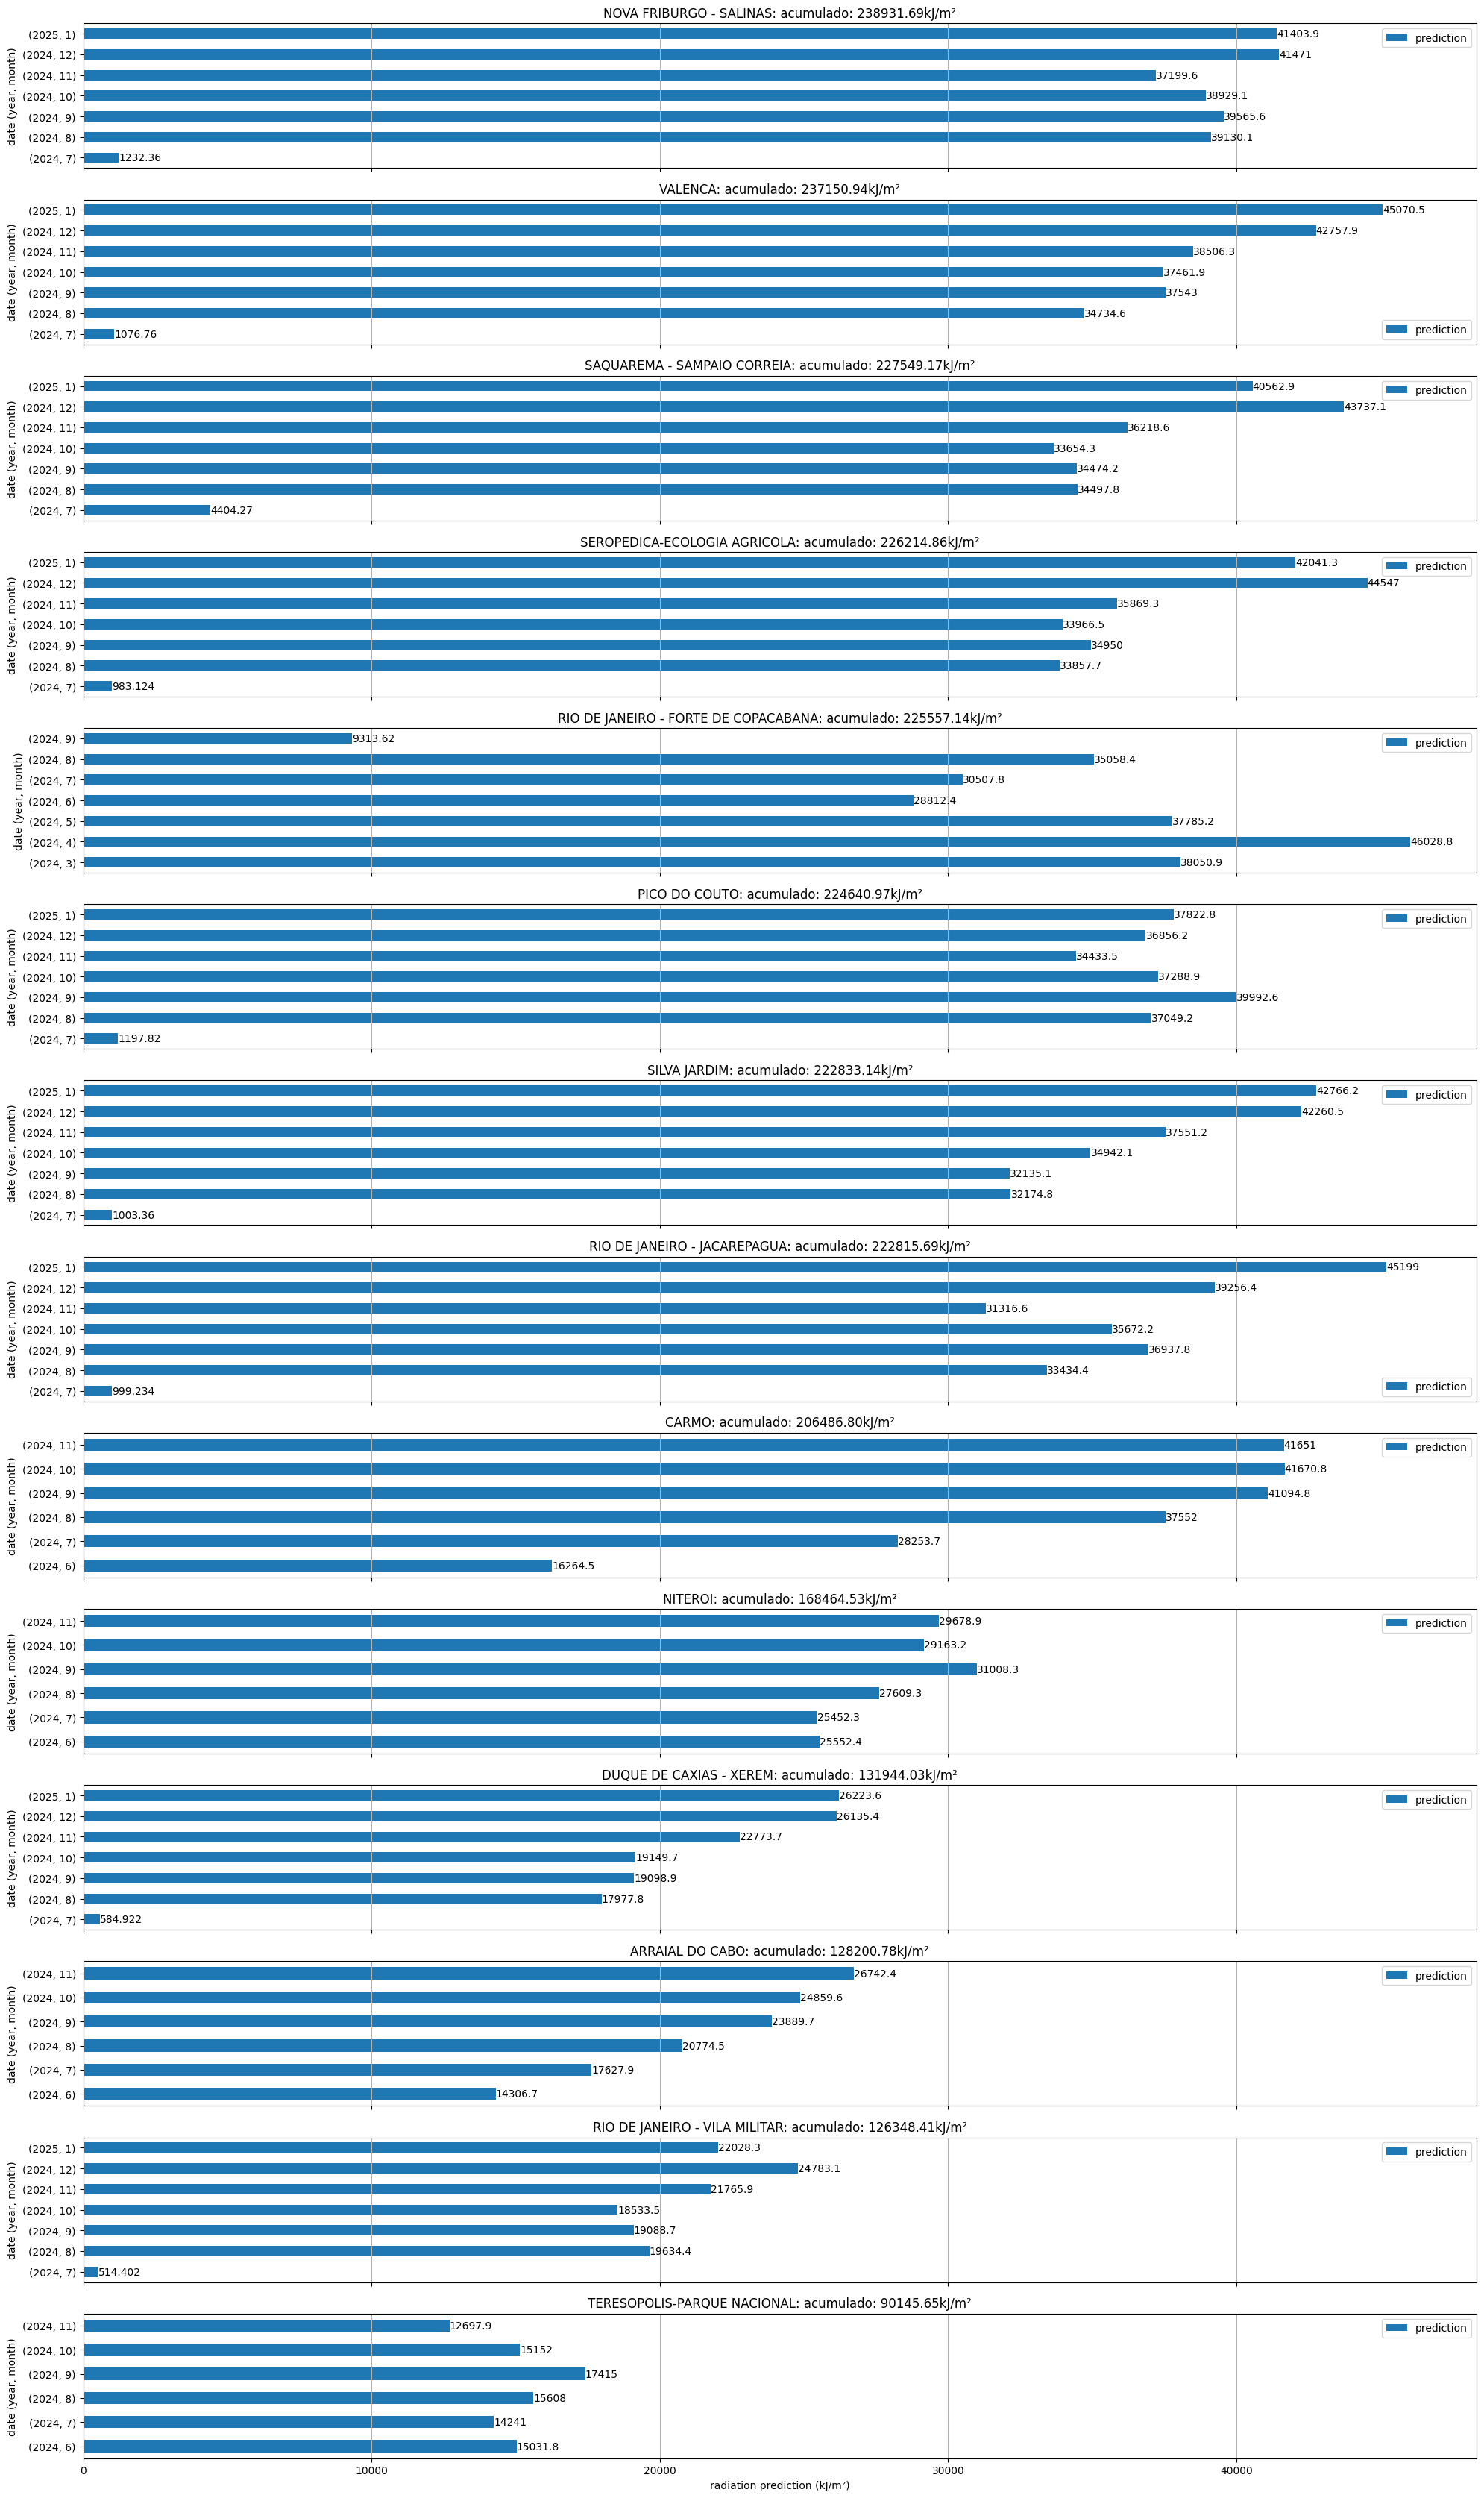

In [11]:
fig, axes = plt.subplots(len(predictions), sharex=True)
fig.set_figwidth(FIGSIZE[0])
fig.set_figheight(len(predictions) * 0.4 * FIGSIZE[1])


sorted_keys = sorted(
    predictions, key=(lambda k: predictions[k].prediction.sum()), reverse=True
)
for i, code in enumerate(sorted_keys):
    p = predictions[code]
    station_name = in_radius.loc[in_radius.code == code, "station-name"].iloc[0]
    by_month = p.groupby([p.index.year, p.index.month]).sum()
    axes[i].set_title(
        f"{station_name}: acumulado: {by_month.prediction.sum():.2f}kJ/m²"
    )
    ax = by_month.plot.barh(
        ax=axes[i], ylabel="date (year, month)", xlabel="radiation prediction (kJ/m²)"
    )
    ax.grid(visible=True, which="major", axis="x")
    for c in ax.containers:
        ax.bar_label(c)
    ax
plt.tight_layout()